# Import libraries


In [1]:
import pandas as pd
import torch
import ltn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 1. Initial data analysis

In [2]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)

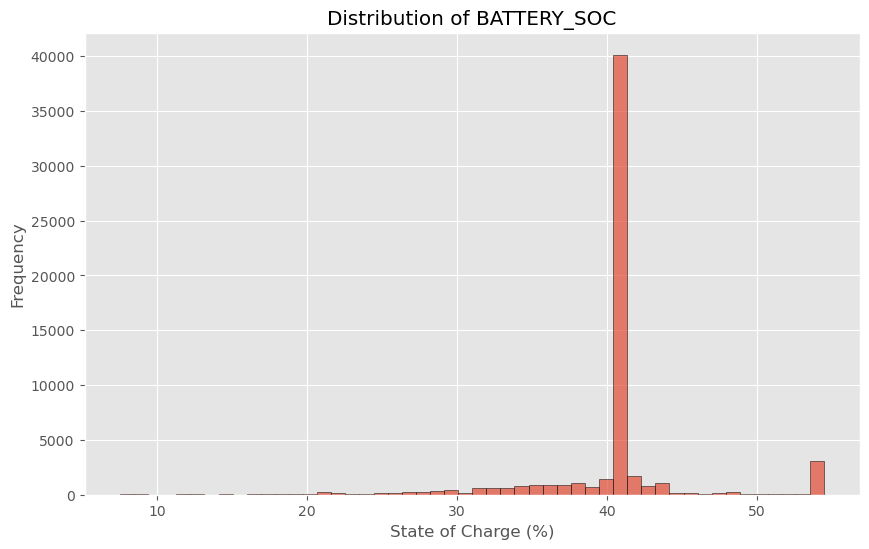

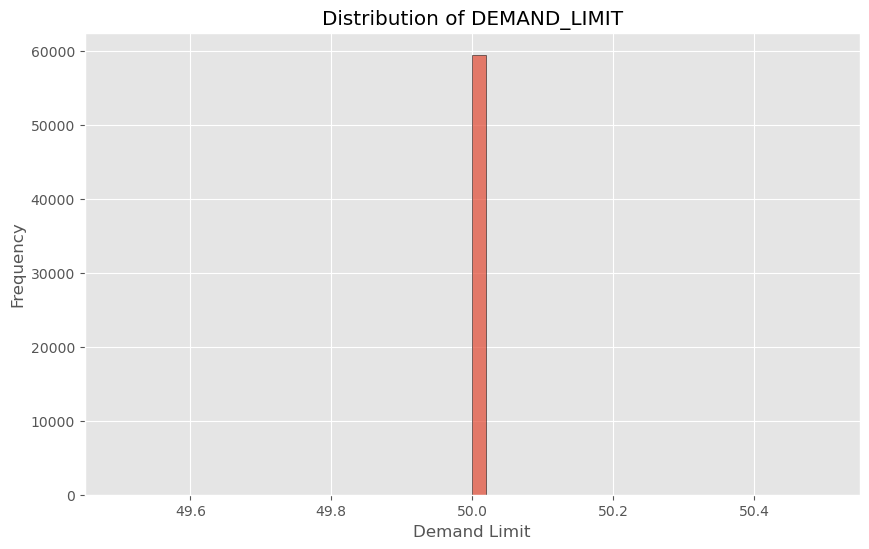

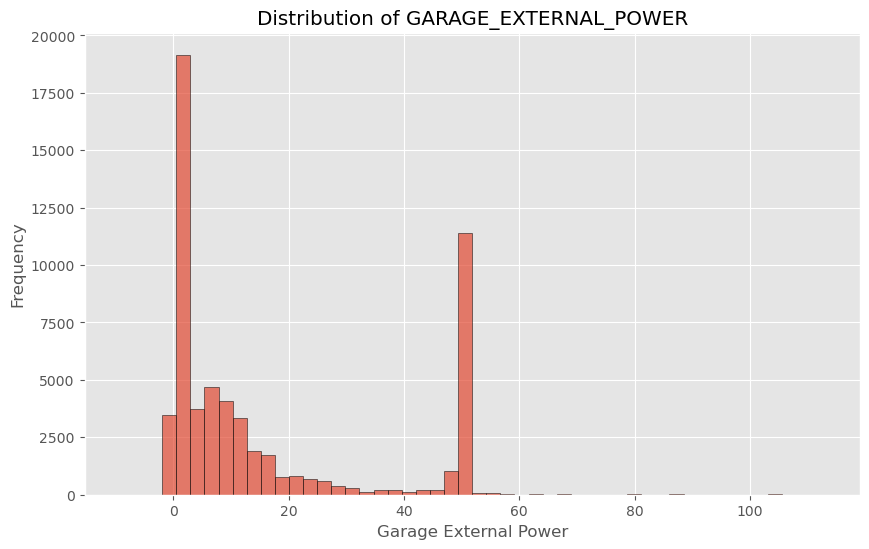

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.hist(data['BATTERY_SOC'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of BATTERY_SOC')
plt.xlabel('State of Charge (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Plot distribution of DEMAND_LIMIT
plt.figure(figsize=(10, 6))
plt.hist(data['DEMAND_LIMIT'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of DEMAND_LIMIT')
plt.xlabel('Demand Limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Plot distribution of GARAGE_EXTERNAL_POWER
plt.figure(figsize=(10, 6))
plt.hist(data['GARAGE_EXTERNAL_POWER'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of GARAGE_EXTERNAL_POWER')
plt.xlabel('Garage External Power')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- The majority of the battery state of charge (SOC) values are clustered around 40%, with a few instances of higher values.
There are minimal instances of SOC below 40%, indicating that the battery is often maintained around this threshold.
This distribution suggests that the battery SOC rarely goes below the 40% threshold, indicating a controlled use of the battery to prevent deep discharge and maintain its health.

- From the distribution of BATTERY_SOC, we can infer that the system maintains the SOC around 40%. This might indicate a learned or programmed behavior to prevent deep discharge.
The GARAGE_EXTERNAL_POWER distribution shows that the battery is likely used to prevent external power draw from exceeding the DEMAND_LIMIT.

- The demand limit is highly concentrated around 50, indicating a strict threshold for external grid power draw.
The system appears to be designed to maintain this limit consistently, as deviations from this value are extremely rare.
This implies that the system is effectively implementing peak-shaving to manage the power drawn from the grid.

- There are two prominent peaks: one around 0 and another around 50.
The peak at 0 suggests that the system often does not draw power from the external grid, possibly relying on the local battery or PV.
The peak around 50 aligns with the DEMAND_LIMIT, indicating that when power is drawn from the grid, it often hits this threshold.


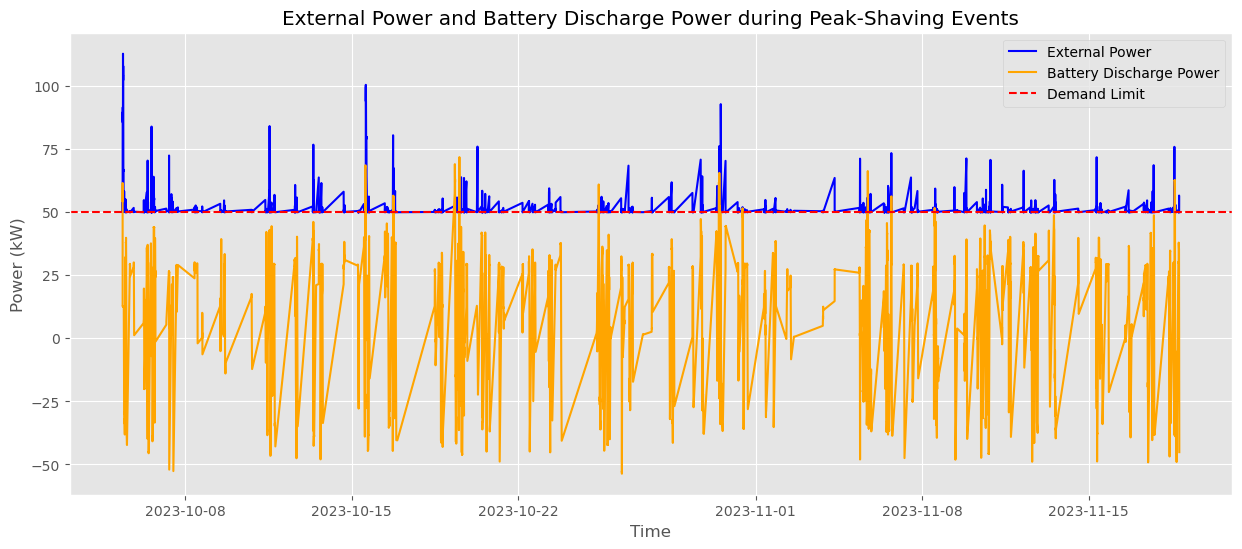

In [5]:
# Filter data where external power exceeds the demand limit
peak_shaving_events = data[data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT']]
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(peak_shaving_events['_time']), peak_shaving_events['GARAGE_EXTERNAL_POWER'], label='External Power', color='blue')
plt.plot(pd.to_datetime(peak_shaving_events['_time']), peak_shaving_events['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
plt.axhline(y=data['DEMAND_LIMIT'].iloc[0], color='r', linestyle='--', label='Demand Limit')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('External Power and Battery Discharge Power during Peak-Shaving Events')
plt.legend()
plt.show()


- SOC > 80%
- 40% < SOC <= 80%
- 15% < SOC <= 40%
- SOC <= 15%

We'll then examine the battery discharge power in each segment when the external power exceeds the demand limit.

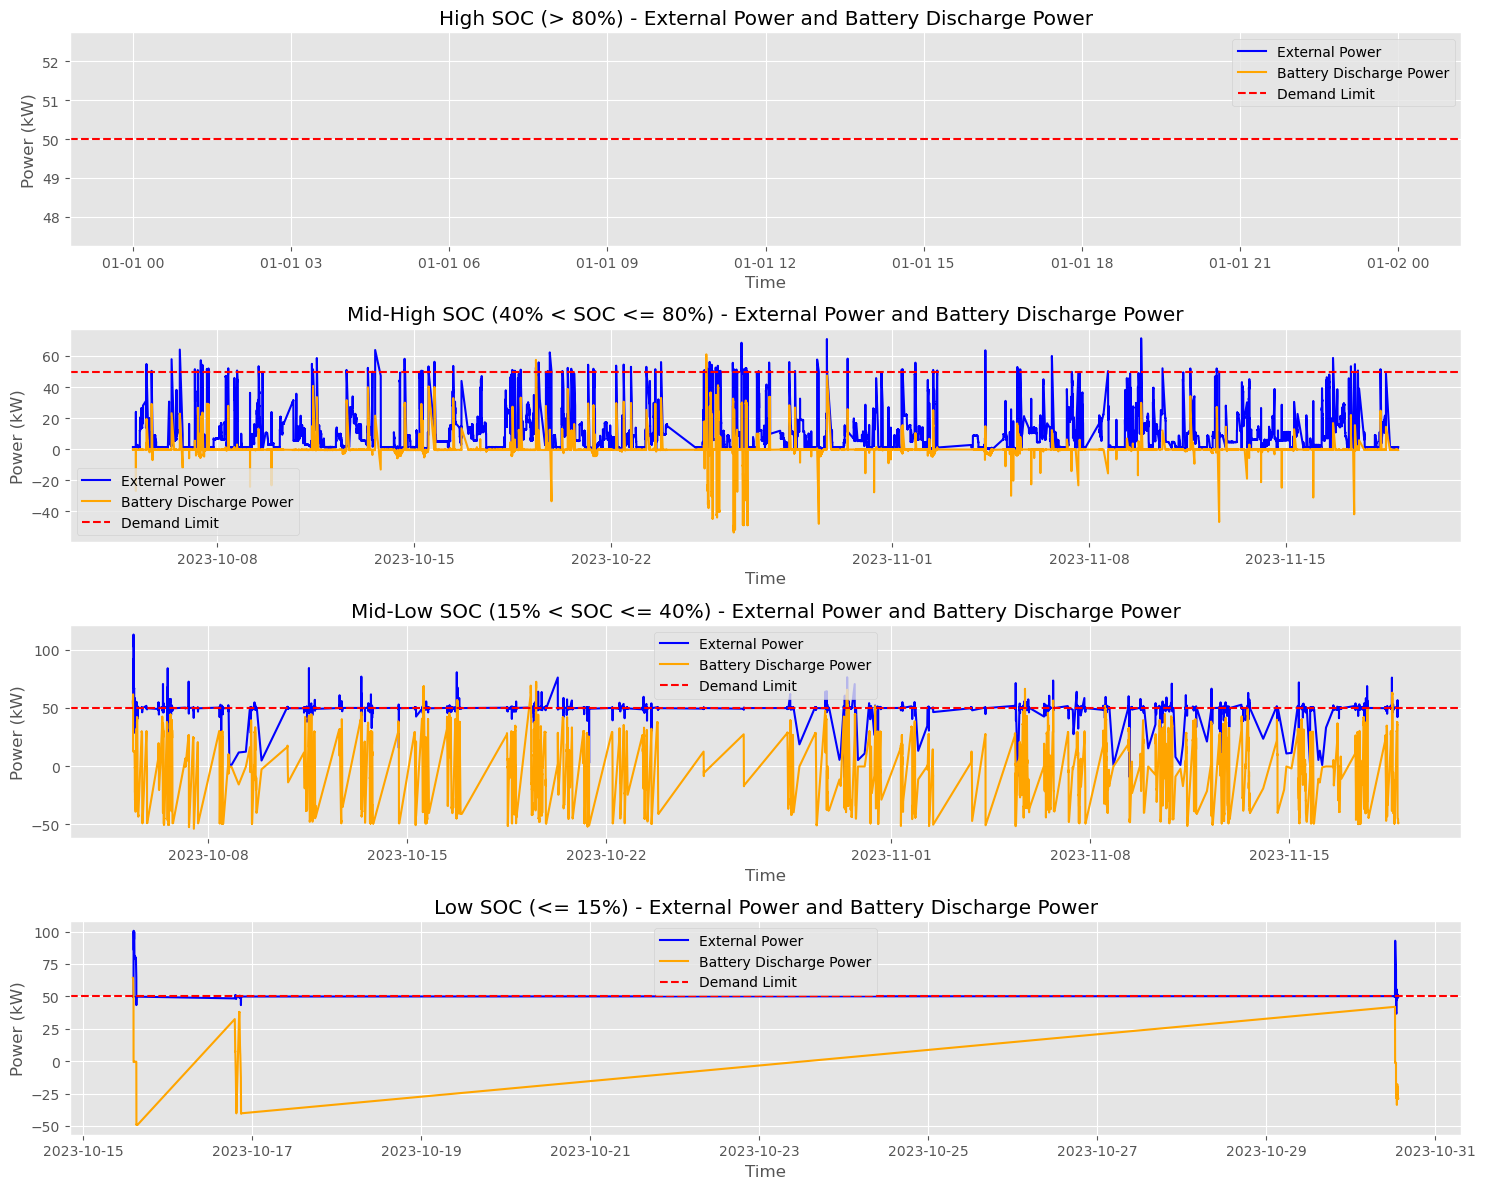

In [6]:
# Define SOC thresholds
high_soc = data[data['BATTERY_SOC'] > 80]
mid_high_soc = data[(data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] <= 80)]
mid_low_soc = data[(data['BATTERY_SOC'] > 15) & (data['BATTERY_SOC'] <= 40)]
low_soc = data[data['BATTERY_SOC'] <= 15]
# Plot peak-shaving events for each SOC segment
plt.figure(figsize=(15, 12))
# High SOC segment
plt.subplot(4, 1, 1)
plt.plot(pd.to_datetime(high_soc['_time']), high_soc['GARAGE_EXTERNAL_POWER'], label='External Power', color='blue')
plt.plot(pd.to_datetime(high_soc['_time']), high_soc['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
plt.axhline(y=data['DEMAND_LIMIT'].iloc[0], color='r', linestyle='--', label='Demand Limit')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('High SOC (> 80%) - External Power and Battery Discharge Power')
plt.legend()
# Mid-High SOC segment
plt.subplot(4, 1, 2)
plt.plot(pd.to_datetime(mid_high_soc['_time']), mid_high_soc['GARAGE_EXTERNAL_POWER'], label='External Power', color='blue')
plt.plot(pd.to_datetime(mid_high_soc['_time']), mid_high_soc['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
plt.axhline(y=data['DEMAND_LIMIT'].iloc[0], color='r', linestyle='--', label='Demand Limit')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Mid-High SOC (40% < SOC <= 80%) - External Power and Battery Discharge Power')
plt.legend()
# Mid-Low SOC segment
plt.subplot(4, 1, 3)
plt.plot(pd.to_datetime(mid_low_soc['_time']), mid_low_soc['GARAGE_EXTERNAL_POWER'], label='External Power', color='blue')
plt.plot(pd.to_datetime(mid_low_soc['_time']), mid_low_soc['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
plt.axhline(y=data['DEMAND_LIMIT'].iloc[0], color='r', linestyle='--', label='Demand Limit')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Mid-Low SOC (15% < SOC <= 40%) - External Power and Battery Discharge Power')
plt.legend()
# Low SOC segment
plt.subplot(4, 1, 4)
plt.plot(pd.to_datetime(low_soc['_time']), low_soc['GARAGE_EXTERNAL_POWER'], label='External Power', color='blue')
plt.plot(pd.to_datetime(low_soc['_time']), low_soc['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
plt.axhline(y=data['DEMAND_LIMIT'].iloc[0], color='r', linestyle='--', label='Demand Limit')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Low SOC (<= 15%) - External Power and Battery Discharge Power')
plt.legend()

plt.tight_layout()
plt.show()


### Attempt to identify peak-shaving events

In [8]:
# Function to identify peak-shaving events
def identify_peak_shaving_events(data, demand_limit):
    peak_shaving_events = []
    current_event = None
    
    for index, row in data.iterrows():
        if row['GARAGE_EXTERNAL_POWER'] > demand_limit:
            if current_event is None:
                current_event = {
                    'start_time': row['_time'],
                    'end_time': row['_time'],
                    'duration': 1,
                    'peak_power': row['GARAGE_EXTERNAL_POWER'],
                    'battery_support': row['BATTERY_DISCHARGE_POWER']
                }
            else:
                current_event['end_time'] = row['_time']
                current_event['duration'] += 1
                current_event['peak_power'] = max(current_event['peak_power'], row['GARAGE_EXTERNAL_POWER'])
                current_event['battery_support'] += row['BATTERY_DISCHARGE_POWER']
        else:
            if current_event is not None:
                peak_shaving_events.append(current_event)
                current_event = None
    
    if current_event is not None:
        peak_shaving_events.append(current_event)
    
    return peak_shaving_events
demand_limit = data['DEMAND_LIMIT'].iloc[0]

high_soc_events = identify_peak_shaving_events(high_soc, demand_limit)
mid_high_soc_events = identify_peak_shaving_events(mid_high_soc, demand_limit)
mid_low_soc_events = identify_peak_shaving_events(mid_low_soc, demand_limit)
low_soc_events = identify_peak_shaving_events(low_soc, demand_limit)
high_soc_events_df = pd.DataFrame(high_soc_events)
mid_high_soc_events_df = pd.DataFrame(mid_high_soc_events)
mid_low_soc_events_df = pd.DataFrame(mid_low_soc_events)
low_soc_events_df = pd.DataFrame(low_soc_events)

def calculate_event_statistics(events_df):
    stats = {
        'Frequency': len(events_df),
        'Average Duration': events_df['duration'].mean() if not events_df.empty else 0,
        'Total Battery Support (kWh)': events_df['battery_support'].sum() if not events_df.empty else 0,
        'Average Peak Power (kW)': events_df['peak_power'].mean() if not events_df.empty else 0
    }
    return stats
high_soc_stats = calculate_event_statistics(high_soc_events_df)
mid_high_soc_stats = calculate_event_statistics(mid_high_soc_events_df)
mid_low_soc_stats = calculate_event_statistics(mid_low_soc_events_df)
low_soc_stats = calculate_event_statistics(low_soc_events_df)
# Combine statistics into a single DataFrame
stats_df = pd.DataFrame([high_soc_stats, mid_high_soc_stats, mid_low_soc_stats, low_soc_stats],
                        index=['High SOC (> 80%)', 'Mid-High SOC (40% < SOC <= 80%)', 'Mid-Low SOC (15% < SOC <= 40%)', 'Low SOC (<= 15%)'])



stats_df


,Frequency,Average Duration,Total Battery Support (kWh),Average Peak Power (kW)
High SOC (> 80%),0,0.000000,0.000000,0.000000
Mid-High SOC (40% < SOC <= 80%),273,2.120879,7563.929360,51.518438
Mid-Low SOC (15% < SOC <= 40%),1581,2.449715,46314.895356,51.019580
Low SOC (<= 15%),17,5.764706,53.871005,56.149592


Mid-High SOC (40% < SOC <= 80%):

- Frequency: 273 events
- Average Duration: 2.12 minutes
- Total Battery Support: 7563.93 kWh
- Average Peak Power: 51.52 kW
- Mid-Low SOC (15% < SOC <= 40%):

Frequency: 1581 events

- Average Duration: 2.45 minutes
- Total Battery Support: 46314.90 kWh
- Average Peak Power: 51.02 kW
- Low SOC (<= 15%):

Frequency: 17 events

- Average Duration: 5.76 minutes
- Total Battery Support: 53.87 kWh
- Average Peak Power: 56.15 kW

In [9]:
# Function to identify peak-shaving events
def identify_peak_shaving_events(data, demand_limit):
    peak_shaving_events = []
    current_event = None
    
    for index, row in data.iterrows():
        if row['GARAGE_EXTERNAL_POWER'] > demand_limit:
            if current_event is None:
                current_event = {
                    'start_time': row['_time'],
                    'end_time': row['_time'],
                    'duration': 1,
                    'peak_power': row['GARAGE_EXTERNAL_POWER'],
                    'battery_support': row['BATTERY_DISCHARGE_POWER']
                }
            else:
                current_event['end_time'] = row['_time']
                current_event['duration'] += 1
                current_event['peak_power'] = max(current_event['peak_power'], row['GARAGE_EXTERNAL_POWER'])
                current_event['battery_support'] += row['BATTERY_DISCHARGE_POWER']
        else:
            if current_event is not None:
                peak_shaving_events.append(current_event)
                current_event = None
    
    if current_event is not None:
        peak_shaving_events.append(current_event)
    
    return peak_shaving_events

In [10]:
# Function to calculate statistics for peak-shaving events
def calculate_event_statistics(events_df):
    stats = {
        'Frequency': len(events_df),
        'Average Duration': events_df['duration'].mean() if not events_df.empty else 0,
        'Total Battery Support (kWh)': events_df['battery_support'].sum() if not events_df.empty else 0,
        'Average Peak Power (kW)': events_df['peak_power'].mean() if not events_df.empty else 0
    }
    return stats


In [11]:
# Function to evaluate SOC thresholds
def evaluate_soc_thresholds(data, thresholds, demand_limit):
    soc_high, soc_mid_high, soc_mid_low, soc_low = thresholds
    
    # Segment data based on SOC thresholds
    high_soc = data[data['BATTERY_SOC'] > soc_high]
    mid_high_soc = data[(data['BATTERY_SOC'] > soc_mid_high) & (data['BATTERY_SOC'] <= soc_high)]
    mid_low_soc = data[(data['BATTERY_SOC'] > soc_mid_low) & (data['BATTERY_SOC'] <= soc_mid_high)]
    low_soc = data[data['BATTERY_SOC'] <= soc_mid_low]

    # Identify peak-shaving events for each SOC segment
    high_soc_events = identify_peak_shaving_events(high_soc, demand_limit)
    mid_high_soc_events = identify_peak_shaving_events(mid_high_soc, demand_limit)
    mid_low_soc_events = identify_peak_shaving_events(mid_low_soc, demand_limit)
    low_soc_events = identify_peak_shaving_events(low_soc, demand_limit)

    # Convert to DataFrame for easier analysis
    high_soc_events_df = pd.DataFrame(high_soc_events)
    mid_high_soc_events_df = pd.DataFrame(mid_high_soc_events)
    mid_low_soc_events_df = pd.DataFrame(mid_low_soc_events)
    low_soc_events_df = pd.DataFrame(low_soc_events)

    # Calculate statistics for each SOC segment
    high_soc_stats = calculate_event_statistics(high_soc_events_df)
    mid_high_soc_stats = calculate_event_statistics(mid_high_soc_events_df)
    mid_low_soc_stats = calculate_event_statistics(mid_low_soc_events_df)
    low_soc_stats = calculate_event_statistics(low_soc_events_df)

    # Combine total battery support for all SOC segments
    total_battery_support = (high_soc_stats['Total Battery Support (kWh)'] +
                             mid_high_soc_stats['Total Battery Support (kWh)'] +
                             mid_low_soc_stats['Total Battery Support (kWh)'] +
                             low_soc_stats['Total Battery Support (kWh)'])
    
    # Calculate average peak power across all segments
    average_peak_power = (high_soc_stats['Average Peak Power (kW)'] +
                          mid_high_soc_stats['Average Peak Power (kW)'] +
                          mid_low_soc_stats['Average Peak Power (kW)'] +
                          low_soc_stats['Average Peak Power (kW)']) / 4

    return total_battery_support, average_peak_power

# Define range of SOC thresholds to explore
soc_ranges = np.arange(10, 90, 10)
optimal_thresholds = None
max_battery_support = -np.inf
best_average_peak_power = np.inf

# Perform grid search over SOC thresholds
demand_limit = data['DEMAND_LIMIT'].iloc[0]

for soc_high in soc_ranges:
    for soc_mid_high in soc_ranges:
        if soc_mid_high >= soc_high:
            continue
        for soc_mid_low in soc_ranges:
            if soc_mid_low >= soc_mid_high:
                continue
            thresholds = (soc_high, soc_mid_high, soc_mid_low, 15)  # Fix the lowest threshold at 15%
            total_battery_support, average_peak_power = evaluate_soc_thresholds(data, thresholds, demand_limit)
            
            # Update optimal thresholds based on criteria
            if total_battery_support > max_battery_support and average_peak_power < best_average_peak_power:
                max_battery_support = total_battery_support
                best_average_peak_power = average_peak_power
                optimal_thresholds = thresholds

optimal_thresholds, max_battery_support, best_average_peak_power

((30, 20, 10, 15), 53932.695721398806, 62.43371071318727)

### Random forest


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
y_class = pd.cut(data['BATTERY_SOC'], bins=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
# Train the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
sfm = SelectFromModel(rfc, threshold='mean', prefit=True)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)
rfc_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_selected.fit(X_train_selected, y_train)
y_pred = rfc_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

importances = rfc.feature_importances_
important_features = X.columns[sfm.get_support()]

accuracy, list(zip(X.columns, importances)), important_features.tolist()



/Users/jevgenijposaskov/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jevgenijposaskov/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(0.9385059843169624,
 [('GARAGE_EXTERNAL_POWER', 0.03688528999916159),
  ('DEMAND_LIMIT', 0.0),
  ('DEMAND_LIMIT_INDICATOR', 0.0),
  ('BATTERY_DISCHARGE_POWER', 0.06751810528034762),
  ('BATTERY_CHARGED_ENERGY', 0.014401643008786994),
  ('BATTERY_DISCHARGED_ENERGY', 0.016426201731985543),
  ('PV_POWER', 0.08656649354551228),
  ('PV_ENERGY', 0.025691430537199536),
  ('WALLBOX_ALPHA_ENERGY', 0.017035584045292273),
  ('WALLBOX_ALPHA_POWER', 0.07881565904353278),
  ('WALLBOX_1_ENERGY', 0.010665499617500495),
  ('WALLBOX_1_POWER', 0.07123234897655056),
  ('WALLBOX_2_ENERGY', 0.008956964513883893),
  ('WALLBOX_2_POWER', 0.07915931237577602),
  ('WALLBOX_3_ENERGY', 0.022856571389820956),
  ('WALLBOX_3_POWER', 0.07122891744945825),
  ('WALLBOX_A_ENERGY', 0.022143058025474116),
  ('WALLBOX_A_POWER', 0.07211409246062435),
  ('WALLBOX_B_ENERGY', 0.020951877942447104),
  ('WALLBOX_B_POWER', 0.06838907137562235),
  ('WALLBOX_C_ENERGY', 0.02879607136313925),
  ('WALLBOX_C_POWER', 0.08136294722188461

### 2. Tourch NN

In [3]:
# Convert '_time' from string to datetime
data['_time'] = pd.to_datetime(data['_time'])
# Assume we're using all columns except '_time' and 'BATTERY_SOC' as features
features = data.drop(columns=['_time', 'BATTERY_SOC'])
targets = data['BATTERY_SOC']
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# Convert to numpy arrays
features_numpy = np.array(features_scaled, dtype=np.float32)
targets_numpy = np.array(targets.values, dtype=np.float32).reshape(-1, 1)  # Reshape to make it a column vector
# Neural network model
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super(BatteryManagementModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(features.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define accuracy for regression
def regression_accuracy(outputs, targets, threshold=5.0):
    correct = (torch.abs(outputs - targets) <= threshold).float()
    accuracy = correct.mean()
    return accuracy.item() * 100
# Manual batching
def manual_batching(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]
def train(model, features, targets, batch_size=64, epochs=100):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        indices = np.arange(features_tensor.shape[0])
        np.random.shuffle(indices)
        for batch_indices in manual_batching(indices, batch_size):
            batch_features = features_tensor[batch_indices]
            batch_targets = targets_tensor[batch_indices]
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += regression_accuracy(outputs, batch_targets)
        average_loss = running_loss / (len(indices) / batch_size)
        average_accuracy = running_accuracy / (len(indices) / batch_size)
        print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {average_accuracy:.2f}%')
# Testing function
def test(model, features, targets, batch_size=64):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    count = 0
    with torch.no_grad():
        for batch_features, batch_targets in zip(manual_batching(features_tensor, batch_size), manual_batching(targets_tensor, batch_size)):
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item() * batch_features.size(0)
            total_accuracy += regression_accuracy(outputs, batch_targets)
            count += 1
    average_loss = total_loss / len(features)
    average_accuracy = total_accuracy / count
    print(f' Test Accuracy: {average_accuracy:.2f}%')
# Train and test the model
train(model, features_numpy, targets_numpy, batch_size=64, epochs=100)
test(model, features_numpy, targets_numpy, batch_size=64)


Epoch 1/100, Accuracy: 64.76%
Epoch 2/100, Accuracy: 82.24%
Epoch 3/100, Accuracy: 84.77%


KeyboardInterrupt: 

### 3. Rules satisfaction wirh LTN

### Our initial dataset and model with constraints

- 40% < SOC < 80%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
- SOC < 40%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
    - If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
- SOC < 15%: Battery discharging is stopped due to battery health

In [4]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = data[(data["BATTERY_SOC"]<=15) & (data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<50) & (data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=data["GARAGE_EXTERNAL_POWER"]) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = data[(data["BATTERY_SOC"]>=40) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [5]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)

In [7]:
generalized_df = data.copy()
generalized_df["DRAWN_FROM"] = generalized_df.apply(label_charging, axis=1)

In [8]:
(generalized_df["DRAWN_FROM"] == 'Partially Covered by Local Battery').sum()

4457

In [7]:
(generalized_df["DRAWN_FROM"] == 'Battery Charged from Grid').sum()

54783

In [8]:
(generalized_df["DRAWN_FROM"] == 'Battery Discharge Stopped due to Battery Health').sum()

202

In [9]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']

## Check rules from NN

### Take same rules from Urh's imlementation

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

In [11]:
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

In [12]:
data = X_verify

### Model based on BATTERY_SOC

Epoch 0: Loss 0.6092910170555115, Combined Satisfaction 0.3907089829444885
Epoch 100: Loss 0.40629464387893677, Combined Satisfaction 0.5937053561210632
Epoch 200: Loss 0.40538132190704346, Combined Satisfaction 0.5946186780929565
Epoch 300: Loss 0.4050379991531372, Combined Satisfaction 0.5949620008468628
Epoch 400: Loss 0.40487372875213623, Combined Satisfaction 0.5951262712478638
Epoch 500: Loss 0.40478384494781494, Combined Satisfaction 0.5952161550521851
Epoch 600: Loss 0.4047297239303589, Combined Satisfaction 0.5952702760696411
Epoch 700: Loss 0.4046945571899414, Combined Satisfaction 0.5953054428100586
Epoch 800: Loss 0.40467095375061035, Combined Satisfaction 0.5953290462493896
Epoch 900: Loss 0.40465450286865234, Combined Satisfaction 0.5953454971313477
Final Loss: 0.40464234352111816, Final Combined Satisfaction: 0.5953576564788818


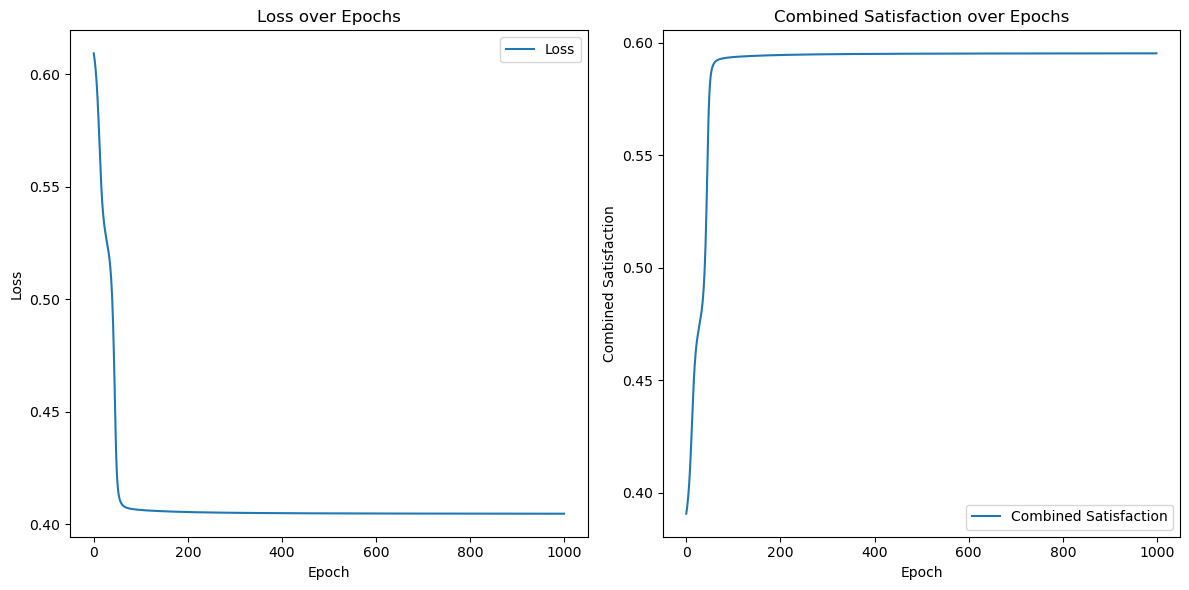

In [13]:
# Assuming `mlp_simple` is defined and trained elsewhere in your code
# Generate predictions using `mlp_simple`
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)
# Add a mock column for GARAGE_EXTERNAL_POWER and DEMAND_LIMIT for demonstration
X_verify['GARAGE_EXTERNAL_POWER'] = np.random.uniform(0, 100, len(X_verify))
X_verify['DEMAND_LIMIT'] = 50
data = X_verify  # Ensure data includes the added columns
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).unsqueeze(-1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
GARAGE_EXTERNAL_POWER = ltn.Variable('garage_power', power_tensor)
DEMAND_LIMIT = ltn.Variable('demand_limit', demand_limit_tensor)
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 4),  # Adjusted to output 4 values for 4 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()

# Define the conditions function
def conditions(soc, garage_power):
    inputs = torch.cat([soc.value, garage_power.value], dim=1)
    return model(inputs)
# Define the LTN predicates using functions
def greater_than_80(x):
    return x > 80
def between_40_and_80(x):
    return (x > 40) & (x <= 80)
def less_than_40(x):
    return x <= 40
def less_than_15(x):
    return x < 15
def greater_than_demand_limit(garage_power, demand_limit):
    return garage_power > demand_limit
# Instantiate predicates
SOC_gt_80 = ltn.Predicate(func=greater_than_80)
SOC_between_40_and_80 = ltn.Predicate(func=between_40_and_80)
SOC_lt_40 = ltn.Predicate(func=less_than_40)
SOC_lt_15 = ltn.Predicate(func=less_than_15)
GARAGE_POWER_gt_DEMAND_LIMIT = ltn.Predicate(func=greater_than_demand_limit)
# Define the logical rules as functions
def rule1():
    condition = SOC_gt_80(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 0]
def rule2():
    condition = torch.logical_and(SOC_between_40_and_80(SOC).value, 
                                  GARAGE_POWER_gt_DEMAND_LIMIT(GARAGE_EXTERNAL_POWER, DEMAND_LIMIT).value)
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 1]
def rule3():
    condition = torch.logical_and(SOC_lt_40(SOC).value, 
                                  GARAGE_POWER_gt_DEMAND_LIMIT(GARAGE_EXTERNAL_POWER, DEMAND_LIMIT).value)
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 2]
def rule4():
    condition = SOC_lt_15(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 3]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    sat_rule4 = evaluate_rule(rule4())
    return logical_or(sat_rule1, sat_rule2, sat_rule3, sat_rule4), sat_rule1, sat_rule2, sat_rule3, sat_rule4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
satisfactions1 = []
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction1, sat_rule1, sat_rule2, sat_rule3, sat_rule4 = axioms()
    loss = 1 - satisfaction1
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions1.append(satisfaction1.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction1.item()}")
print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction1.item()}")
# Plot the loss and combined satisfaction for each epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(satisfactions1, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)
data = X_verify

Epoch 0: Loss 0.7869794964790344, Combined Satisfaction 0.21302050352096558
Epoch 1: Loss 0.7785370945930481, Combined Satisfaction 0.2214629054069519
Epoch 2: Loss 0.7698101997375488, Combined Satisfaction 0.23018980026245117
Epoch 3: Loss 0.760881245136261, Combined Satisfaction 0.239118754863739
Epoch 4: Loss 0.7518458962440491, Combined Satisfaction 0.24815410375595093
Epoch 5: Loss 0.7427875399589539, Combined Satisfaction 0.25721246004104614
Epoch 6: Loss 0.7337886691093445, Combined Satisfaction 0.2662113308906555
Epoch 7: Loss 0.7249269485473633, Combined Satisfaction 0.2750730514526367
Epoch 8: Loss 0.7162652015686035, Combined Satisfaction 0.2837347984313965
Epoch 9: Loss 0.7080702185630798, Combined Satisfaction 0.29192978143692017
Epoch 10: Loss 0.7012141346931458, Combined Satisfaction 0.29878586530685425
Epoch 11: Loss 0.6947747468948364, Combined Satisfaction 0.3052252531051636
Epoch 12: Loss 0.6885941624641418, Combined Satisfaction 0.31140583753585815
Epoch 13: Loss 0.

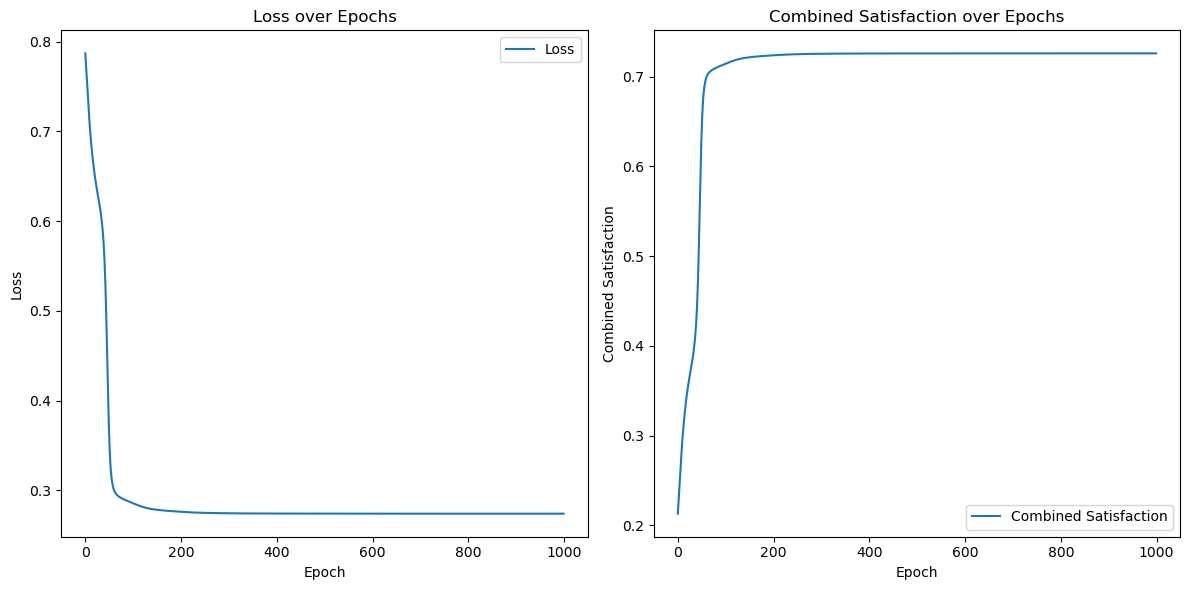

In [15]:
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  #  3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Define the conditions function
def conditions(soc):
    inputs = soc.value
    return model(inputs)
# Define the LTN predicates using functions
def less_than_15(x):
    return x < 17
def between_15_and_47(x):
    return (x >= 17) & (x <= 47.5)
def greater_than_47(x):
    return x > 47.5
# Instantiate predicates
SOC_lt_15 = ltn.Predicate(func=less_than_15)
SOC_between_15_and_47 = ltn.Predicate(func=between_15_and_47)
SOC_gt_47 = ltn.Predicate(func=greater_than_47)
# Define the logical rules as functions
def rule1():
    condition = SOC_lt_15(SOC).value
    return condition * conditions(SOC)[:, 0]
def rule2():
    condition = SOC_between_15_and_47(SOC).value
    return condition * conditions(SOC)[:, 1]
def rule3():
    condition = SOC_gt_47(SOC).value
    return condition * conditions(SOC)[:, 2]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
satisfactions2 = []

for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction2, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction2
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions2.append(satisfaction2.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction2.item()}")
print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction2.item()}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(satisfactions2, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
data = pd.read_csv(file_path)

### Checking rules for 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC', "WALLBOX_FASTCHARGER_POWER"]]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC", "WALLBOX_FASTCHARGER_POWER"]])

In [19]:
from sklearn.preprocessing import LabelEncoder

# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)

# Flatten the grid and create a DataFrame from it
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})

# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)

# Initialize a LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder and transform the predictions to numerical data
numerical_predictions = le.fit_transform(predictions)

# Reshape the predictions to the shape of the grid
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)



In [20]:
from sklearn.preprocessing import LabelEncoder

# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)

# Flatten the grid and create a DataFrame from it
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})

# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)

# Initialize a LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder and transform the predictions to numerical data
numerical_predictions = le.fit_transform(predictions)

# Reshape the predictions to the shape of the grid
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)

In [21]:
predictions

array(['Battery Discharge Stopped due to Battery Health',
       'Battery Discharge Stopped due to Battery Health',
       'Battery Discharge Stopped due to Battery Health', ...,
       'Partially Covered by Local Battery',
       'Partially Covered by Local Battery',
       'Partially Covered by Local Battery'], dtype='<U47')

In [22]:
numerical_predictions

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

In [21]:
grid_df['PREDICTIONS'] = predictions

In [22]:
data = grid_df

Epoch 0: Loss 0.4756421446800232, Combined Satisfaction 0.5243578553199768
Epoch 100: Loss 0.24020779132843018, Combined Satisfaction 0.7597922086715698
Epoch 200: Loss 0.23869764804840088, Combined Satisfaction 0.7613023519515991
Epoch 300: Loss 0.23827296495437622, Combined Satisfaction 0.7617270350456238
Epoch 400: Loss 0.2380545735359192, Combined Satisfaction 0.7619454264640808
Final Loss: 0.23804914951324463, Final Combined Satisfaction: 0.7619508504867554


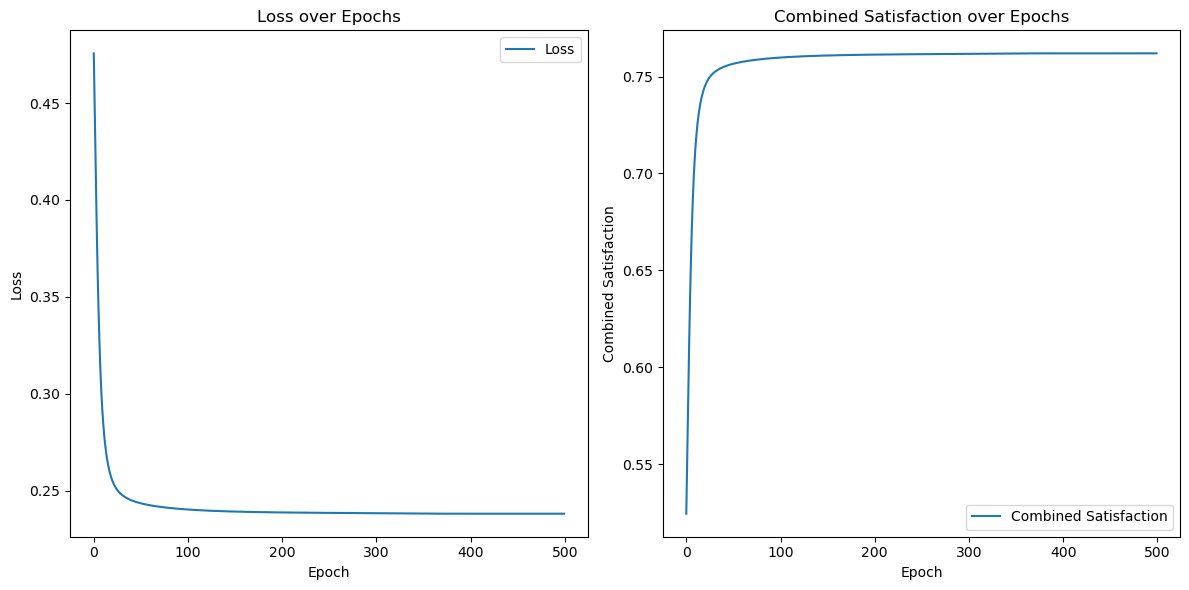

In [23]:
# Prepare the tensors for the LTN variables
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'].values, dtype=torch.float32).unsqueeze(-1)

# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
POWER = ltn.Variable('power', power_tensor)

# Define the BatteryManagementModel
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  # 3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Define the conditions function
def conditions(soc, power):
    inputs = torch.cat((soc.value, power.value), dim=1)
    return model(inputs)

# Define the LTN predicates using functions
def soc_lt_15(x):
    return x < 14

def soc_ge_15(x):
    return x >= 14

def power_lt_50(x):
    return x <= 60

def power_le_70(x):
    return x <= 70

def power_gt_60(x):
    return x > 50

# Instantiate predicates
SOC_lt_15 = ltn.Predicate(func=soc_lt_15)
SOC_ge_15 = ltn.Predicate(func=soc_ge_15)
POWER_lt_50 = ltn.Predicate(func=power_lt_50)
POWER_le_70 = ltn.Predicate(func=power_le_70)
POWER_gt_60 = ltn.Predicate(func=power_gt_60)

# Define the logical rules as functions
def rule1():
    condition = torch.logical_and(SOC_lt_15(SOC).value, POWER_lt_50(POWER).value)
    return condition * conditions(SOC, POWER)[:, 0]

def rule2():
    condition = torch.logical_and(SOC_ge_15(SOC).value, POWER_le_70(POWER).value)
    return condition * conditions(SOC, POWER)[:, 1]

def rule3():
    condition = torch.logical_and(SOC_ge_15(SOC).value, POWER_gt_60(POWER).value)
    return condition * conditions(SOC, POWER)[:, 2]

# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))

def evaluate_rule(rule):
    return torch.mean(rule)

def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
satisfactions3 = []

for epoch in range(500):
    optimizer.zero_grad()
    satisfaction3, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction3
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions3.append(satisfaction3.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction3.item()}")

print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction3.item()}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(satisfactions3, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

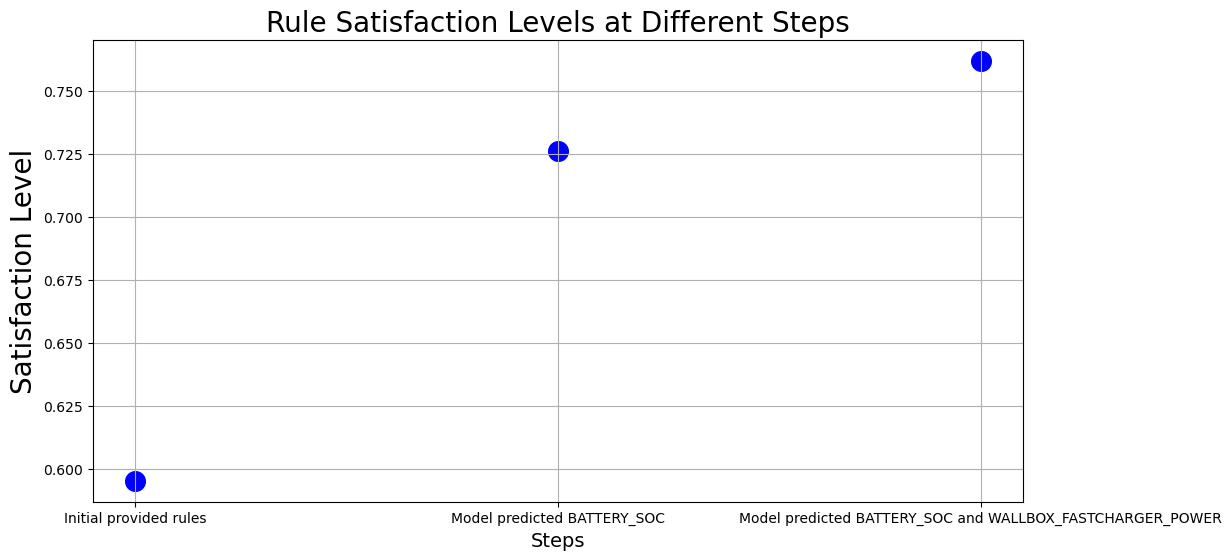

In [24]:
x_labels = ['Initial provided rules', 'Model predicted BATTERY_SOC', 'Model predicted BATTERY_SOC and WALLBOX_FASTCHARGER_POWER']
y_values = [ satisfaction1.item(),  satisfaction2.item(),  satisfaction3.item()]
plt.figure(figsize=(12, 6))
plt.scatter(x_labels, y_values, color='b', s=200)
# Adding titles and labels with bigger font size
plt.title('Rule Satisfaction Levels at Different Steps', fontsize=20)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Satisfaction Level', fontsize=20)

# Adding grid for better readability
plt.grid(True)

# Display the plot
plt.show()


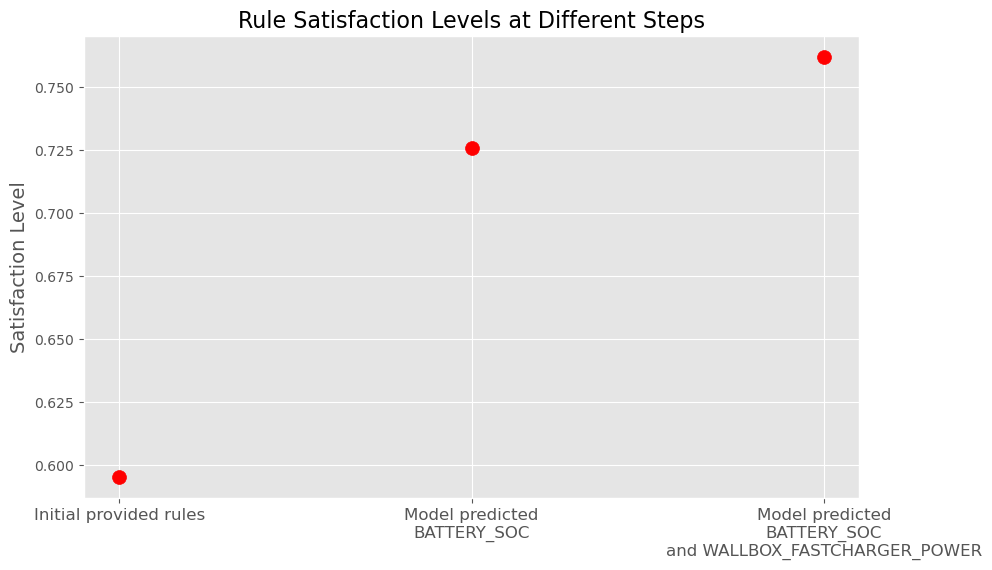

In [26]:
plt.style.use('ggplot')
x_labels = ['Initial provided rules', 
            'Model predicted\nBATTERY_SOC', 
            'Model predicted\nBATTERY_SOC\nand WALLBOX_FASTCHARGER_POWER']
y_values = [ satisfaction1.item(),  satisfaction2.item(),  satisfaction3.item()]
plt.figure(figsize=(10, 6))
plt.scatter(x_labels, y_values, color='r', s=100)  # Increased size of points
plt.title('Rule Satisfaction Levels at Different Steps', fontsize=16)
plt.ylabel('Satisfaction Level', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(True)

plt.show()

## New rules

In [ ]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head(30)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-10-05 00:01:00+00:00,1.244171,50.0,1.0,40.5,-0.338,0.000000,0.0,0.008693,0.000000,...,0.000000,0.006914,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.154965
1,2023-10-05 00:02:00+00:00,1.244171,50.0,1.0,40.5,-0.372,0.000000,0.0,0.008693,0.000000,...,0.000000,0.007550,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.155586
2,2023-10-05 00:03:00+00:00,1.244171,50.0,1.0,40.5,-0.393,0.000000,0.0,0.008693,0.000000,...,0.000000,0.006996,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157340
3,2023-10-05 00:04:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008693,0.000000,...,0.000000,0.007392,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.158009
4,2023-10-05 00:05:00+00:00,1.244171,50.0,1.0,40.5,-0.371,0.000000,0.0,0.008693,0.000000,...,0.000000,0.007188,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.158804
5,2023-10-05 00:06:00+00:00,1.339874,50.0,1.0,40.5,-0.477,0.000000,0.0,0.008693,0.000000,...,0.000000,0.007132,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158213
6,2023-10-05 00:07:00+00:00,1.339874,50.0,1.0,40.5,-0.373,0.000000,0.0,0.008693,0.000000,...,0.000000,0.007680,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158075
7,2023-10-05 00:08:00+00:00,1.244171,50.0,1.0,40.5,-0.359,0.000000,0.0,0.008550,0.000000,...,0.000977,0.006988,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.156482
8,2023-10-05 00:09:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008550,0.000000,...,0.000000,0.007089,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.156322
9,2023-10-05 00:10:00+00:00,1.244171,50.0,1.0,40.5,-0.292,0.000000,0.0,0.008633,0.000000,...,0.000000,0.007034,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157987


In [ ]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = data[(data["BATTERY_SOC"]<=15) & (data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<50) & (data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=data["GARAGE_EXTERNAL_POWER"]) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = data[(data["BATTERY_SOC"]>=40) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [ ]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = data[(data["BATTERY_SOC"]<=15) & (data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<50) & (data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=data["GARAGE_EXTERNAL_POWER"]) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = data[(data["BATTERY_SOC"]>=40) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [ ]:
SOC_less_15 = data[(data["BATTERY_SOC"]<=15)& (data["BATTERY_DISCHARGE_POWER"]<=0)& (data["GARAGE_EXTERNAL_POWER"]>=data["DEMAND_LIMIT"])]
SOC_less_49_more_15 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<47) & (data["GARAGE_EXTERNAL_POWER"]<=data["DEMAND_LIMIT"])]
SOC_more_49 = data[(data["BATTERY_SOC"]>=47) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15,SOC_less_49_more_15, SOC_more_49], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(data)*100}%")

Percentage of dataset, that is kept: 87.44322196426769%
